<a href="https://colab.research.google.com/github/DerekLiu35/ChessCV/blob/main/Chess_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Object detection

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle

import warnings
warnings.filterwarnings('ignore')

# Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derekzliu","key":"daf7776f7ae649d861a2ea84024ca949"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d koryakinp/chess-positions

100% 4.01G/4.01G [00:40<00:00, 97.6MB/s]
100% 4.01G/4.01G [00:40<00:00, 105MB/s] 


In [ ]:
!unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

In [ ]:
train = list(sorted(os.listdir(os.path.join("/content", "train")))) 
test = list(sorted(os.listdir(os.path.join("/content", "test"))))

piece_symbols = 'prbnkqPRBNKQ'

In [ ]:
train[1]

'1B1B1N2-1r6-n2R2k1-7b-1B6-8-8-Kn6.jpeg'

# Helper functions

In [62]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

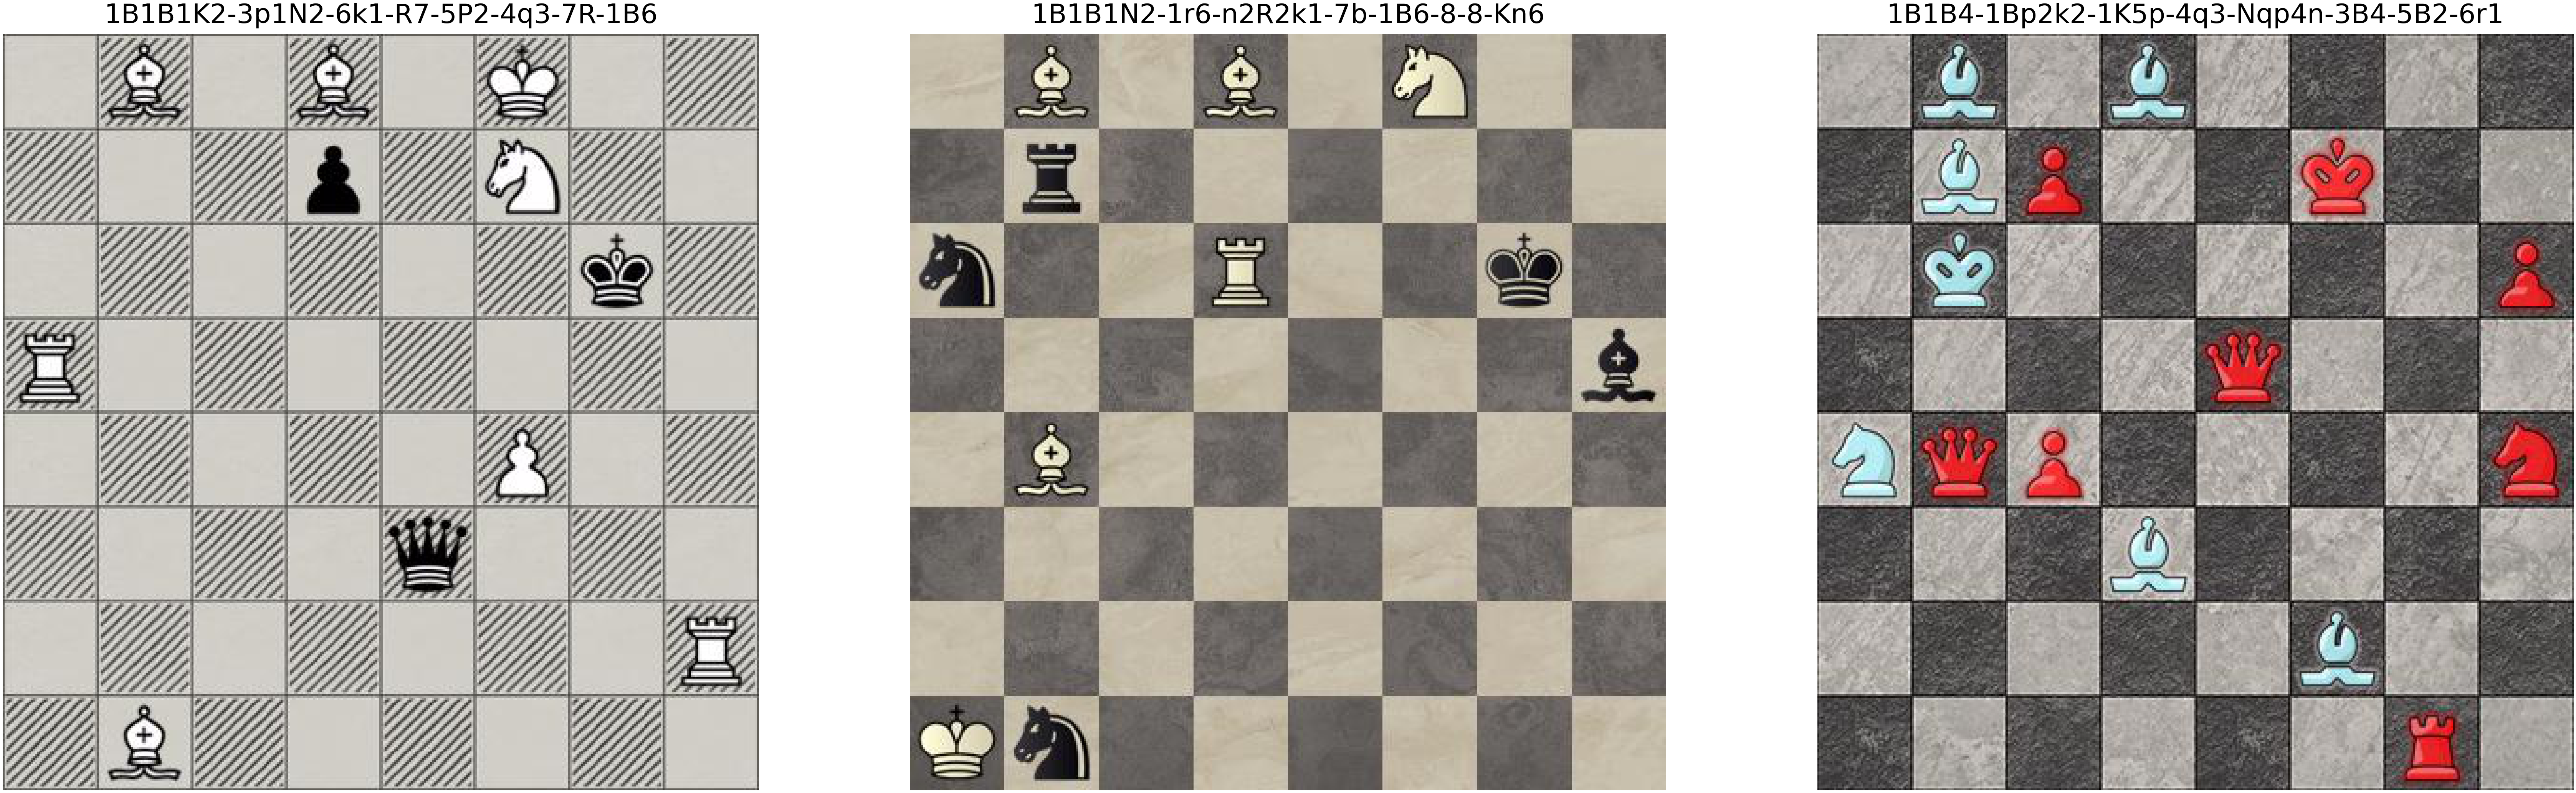

In [63]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(os.path.join('/content', "train", train[i])), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(os.path.join('/content', "train", train[i]))) 
    axarr[i].axis('off')

In [108]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            idx = np.where(one_hot[j*8 + i]==1)[0][0]
            if(idx == 12):
                output += ' '
            else:   
                output += piece_symbols[idx] 
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [65]:
downsample_size = 200
square_size = int(downsample_size/8)
def boxes_labels_from_fen(fen):
    boxes = np.empty((0, 4))
    labels = []
    x = 0
    y = 0
    for char in fen:
        if(char in '12345678'):
          x += int(char) * square_size
        elif char == '-':
          y += square_size
          x = 0
        else:
            boxes = np.append(boxes, [[x, y, x + square_size, y + square_size]], axis = 0)
            x += square_size
            idx = piece_symbols.index(char)
            labels.append(12 - idx)

    return boxes, labels

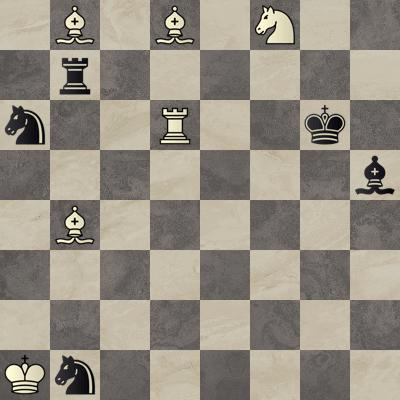

In [66]:
from PIL import Image
img = Image.open(os.path.join('/content', "train", train[1])).convert("RGB")
img

In [67]:
target, labels = boxes_labels_from_fen(fen_from_filename(train[1]))
print(target)
print(labels)


[[ 25.   0.  50.  25.]
 [ 75.   0. 100.  25.]
 [125.   0. 150.  25.]
 [ 25.  25.  50.  50.]
 [  0.  50.  25.  75.]
 [ 75.  50. 100.  75.]
 [150.  50. 175.  75.]
 [175.  75. 200. 100.]
 [ 25. 100.  50. 125.]
 [  0. 175.  25. 200.]
 [ 25. 175.  50. 200.]]
[4, 4, 3, 11, 9, 5, 8, 10, 4, 2, 9]


In [68]:
import torch
import torch.utils.data

root = '/content'
train_size = 1000
test_size = 500

class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # root is 'content' in this notebook
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = list(sorted(os.listdir(os.path.join(root, "train"))))
        shuffle(self.imgs)
        self.imgs = self.imgs[:train_size]
    def __getitem__(self, idx):
        # load images 
        img_path = os.path.join(self.root, "train", self.imgs[idx])

        img = Image.open(img_path).convert("RGB").resize((downsample_size, downsample_size))

        # get bounding box coordinates and labels
        
        fen = fen_from_filename(img_path)
        boxes, labels = boxes_labels_from_fen(fen)
        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)


        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Visualization

In [69]:
# check dataset
dataset = ChessDataset(root)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
dataset[0]
#print(img.shape, '\n',target)


length of dataset =  1000 



(<PIL.Image.Image image mode=RGB size=200x200 at 0x7FA61773BC10>,
 {'boxes': tensor([[ 25.,   0.,  50.,  25.],
          [ 75.,  25., 100.,  50.],
          [125., 100., 150., 125.],
          [  0., 125.,  25., 150.],
          [175., 125., 200., 150.],
          [ 25., 150.,  50., 175.],
          [175., 175., 200., 200.]]),
  'labels': tensor([3, 9, 2, 3, 8, 7, 4]),
  'image_id': tensor([0]),
  'area': tensor([625., 625., 625., 625., 625., 625., 625.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0])})

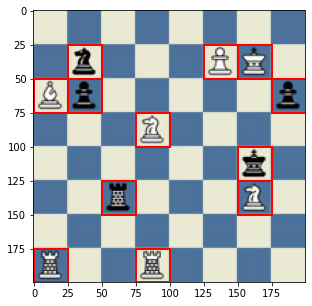

In [70]:
# Function to visualize bounding boxes in the image
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)


# Choose Model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 281682, done.
remote: Counting objects: 100% (2793/2793), done.
remote: Compressing objects: 100% (180/180), done.


In [71]:
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [72]:
import albumentations as A
import transforms as T
from albumentations.pytorch.transforms import ToTensorV2

# Send train=True fro training transforms and False for val/test transforms
# def get_transform(train):
    
#     if train:
#         return A.Compose([
#                             A.HorizontalFlip(0.5),
#                      # ToTensorV2 converts image to pytorch tensor without div by 255
#                             ToTensorV2(p=1.0) 
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
#     else:
#         return A.Compose([
#                             ToTensorV2(p=1.0)
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [73]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = ChessDataset('/content', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions


In [74]:
# use our dataset and defined transformations
dataset = ChessDataset('/content', get_transform(train=False))
dataset_test = ChessDataset('/content', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [75]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 13

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
torch.cuda.empty_cache()

In [76]:
import gc
gc.collect()

13478

# Train Model

In [163]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/95]  eta: 0:06:22  lr: 0.000058  loss: 0.3755 (0.3755)  loss_classifier: 0.2097 (0.2097)  loss_box_reg: 0.1639 (0.1639)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 4.0254  data: 2.1332  max mem: 8613
Epoch: [0]  [10/95]  eta: 0:02:55  lr: 0.000590  loss: 0.3826 (0.3858)  loss_classifier: 0.2277 (0.2264)  loss_box_reg: 0.1550 (0.1576)  loss_objectness: 0.0005 (0.0006)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 2.0701  data: 0.2147  max mem: 8613
Epoch: [0]  [20/95]  eta: 0:02:32  lr: 0.001121  loss: 0.3793 (0.3798)  loss_classifier: 0.2251 (0.2244)  loss_box_reg: 0.1487 (0.1537)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 1.9344  data: 0.0317  max mem: 8613
Epoch: [0]  [30/95]  eta: 0:02:12  lr: 0.001652  loss: 0.3610 (0.3708)  loss_classifier: 0.2122 (0.2188)  loss_box_reg: 0.1459 (0.1504)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 2.0147  data: 0.0380  max mem: 8613
Epoch: [

In [78]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [110]:
len(dataset_test)

50

In [79]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  49
real #boxes:  8


EXPECTED OUTPUT


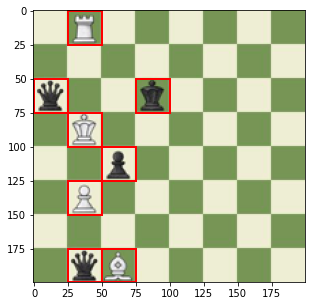

In [80]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


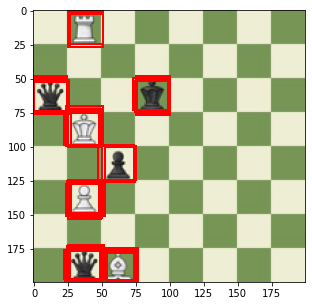

In [82]:
prediction['boxes'] = prediction['boxes'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


NMS APPLIED MODEL OUTPUT


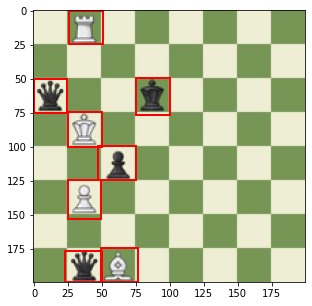

tensor([[4.7019e+01, 9.9582e+01, 7.4884e+01, 1.2456e+02],
        [4.9622e+01, 1.7483e+02, 7.6236e+01, 1.9934e+02],
        [2.5249e+01, 1.2485e+02, 4.9312e+01, 1.5344e+02],
        [2.5073e+01, 7.4831e+01, 5.0002e+01, 1.0043e+02],
        [2.2986e+01, 1.7673e+02, 5.0267e+01, 1.9933e+02],
        [2.6095e+01, 0.0000e+00, 5.0560e+01, 2.4636e+01],
        [6.7296e-02, 5.0628e+01, 2.4010e+01, 7.5394e+01],
        [7.5003e+01, 4.9879e+01, 9.9985e+01, 7.6469e+01]])


In [83]:
prediction['boxes'] = prediction['boxes'].cuda()
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
prediction['boxes'] = prediction['boxes'].cpu()
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)
print(nms_prediction['boxes'])


In [104]:
def boxes_labels_to_fen(boxes, labels):
  boxes = torch.round(boxes / 25) * 25
  eye = np.eye(13)
  one_hot = onehot_from_fen("8-8-8-8-8-8-8-8")
  for i, box in enumerate(boxes):
    x = box[0]
    y = box[1]
    ind = int((x / square_size) + (y / square_size) * 8)
    one_hot[ind] = eye[12 - labels[i]].reshape((1, 13)).astype(int)
  return fen_from_onehot(one_hot)

Nq2n1R1-7n-N7-8-1N5n-2P1K1R1-8-4k3


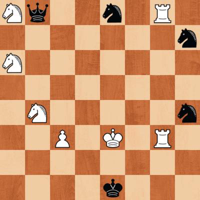

In [174]:
one = boxes_labels_to_fen(nms_prediction['boxes'], nms_prediction['labels'].cpu())
print(one)
torch_to_pil(img)

# Evaluate

In [168]:
import glob
test = glob.glob("/content/test/*.jpeg")

shuffle(test)

test = test[:30]
len(test)

30

In [169]:
model.eval()
with torch.no_grad():
    res = []
    for i in range(30):
      img = Image.open(test[i]).resize((downsample_size, downsample_size))
      img = torchtrans.PILToTensor()(img)/255
      prediction = model([img.to(device)])[0]
      nms_prediction = apply_nms(prediction, iou_thresh=0.2)
      res.append((nms_prediction['boxes'], nms_prediction['labels']))
len(res)

30

In [170]:
res[0]
[boxes_labels_to_fen(boxes, labels) for boxes, labels in res[:30]]

['4B3-7r-8-5K2-2n5-3b4-3P2Rk-8',
 '1r1r1k2-4PR2-3n4-8-1B2Kq2-P2b3r-5R1B-3Q4',
 '6N1-8-bBR3k1-4P3-rr4Q1-q5n1-2b5-2Kr4',
 '8-8-6kp-7N-8-b7-6q1-5K2',
 '1B4n1-4p1q1-4RNR1-5r1p-1K5k-2R2r1P-8-7R',
 '7Q-8-4P3-7k-8-1Kp5-8-8',
 '1R4N1-1b3b2-8-1r1R1R2-1KRN3k-8-1N6-rb4Q1',
 '4k3-8-2K5-8-5n2-B7-8-4R3',
 'n5KB-8-1PB2R2-2p1p1bP-3P3k-8-5r2-3b4',
 '2b2K2-1p6-8-3P4-6B1-5k2-p2r4-8',
 '6rk-B4p2-5pRR-Pp6-8-5r2-1n6-1KN3R1',
 '8-1b6-8-8-4K3-1n2b3-5k2-8',
 'RK2N3-b1r1k3-8-2n5-2n5-3bn3-6N1-1n4B1',
 '5NK1-4b3-3r3B-P4B2-4P2b-4Q1k1-5r1Q-3br3',
 '2n5-5N1P-8-4r3-1R3Nk1-p7-q7-2K5',
 '8-n1B5-3N1Rq1-8-7R-2P5-1K1k1p2-b1Q2r2',
 '6N1-8-8-1p6-8-4K1k1-8-n5R1',
 '3n3b-6P1-8-2r1b3-8-2Q2K1k-8-1r4br',
 '7b-8-7p-b3P1K1-8-6n1-4R2k-7r',
 '2n1n1R1-5p2-8-2p5-8-1RK5-3r4-BRk2Rr1',
 '3n4-n2b4-8-3Nq1pk-8-6Q1-B1bK4-5N1r',
 '1K3k1B-1p6-p7-rq6-1P6-8-7N-n1Bq4',
 '5N2-1K6-4k3-p7-8-2r1N3-2R5-1r6',
 '5R1b-8-6R1-3N4-2Rr4-1P3kP1-3R4-2K5',
 '1bK1q3-3bR3-8-2b4P-8-6N1-5q1k-3nb3',
 '8-4P2R-KB6-5R2-Q2k2rP-3p4-3n2q1-7Q',
 'n7-7k-4R3-2R4R-1Pp5-8-3K3B

In [171]:
pred_fens = np.array([boxes_labels_to_fen(boxes, labels) for (boxes, labels) in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.96667%


Nq2n1R1-7n-N7-8-1N5n-2P1K1R1-8-4k3


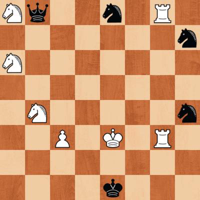

In [172]:
print(pred_fens[29])
Image.open(test[29]).resize((downsample_size, downsample_size))


In [160]:
def display_with_predicted_fen(idx):
    fen = pred_fens[idx]
    imgplot = plt.imshow(mpimg.imread(test[idx]))
    plt.axis('off')
    plt.title(fen)
    plt.show()

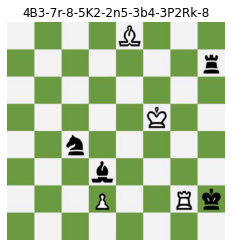

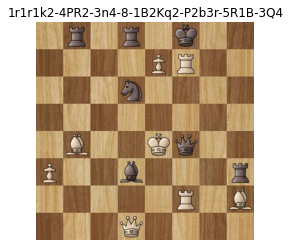

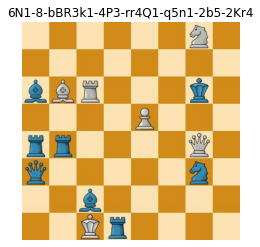

In [173]:
display_with_predicted_fen(0)
display_with_predicted_fen(1)
display_with_predicted_fen(2)